# 目标检测数据集（皮卡丘）

在目标检测领域并没有类似MNIST或Fashion-MNIST那样的小数据集。为了快速测试模型，我们合成了一个小的数据集。我们首先使用一个开源的皮卡丘3D模型生成了1,000张不同角度和大小的皮卡丘图像。然后我们收集了一系列背景图像，并在每张图的随机位置放置一张随机的皮卡丘图像。我们使用MXNet提供的im2rec工具将图像转换成二进制的RecordIO格式 [1]。该格式既可以降低数据集在磁盘上的存储开销，又能提高读取效率。如果想了解更多的图像读取方法，可以查阅GluonCV工具包的文档 [2]。


## 获取数据集

RecordIO格式的皮卡丘数据集可以直接在网上下载。获取数据集的操作定义在`_download_pikachu`函数中。

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, image
from mxnet.gluon import utils as gutils
import os

def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

## 读取数据集

我们通过创建`ImageDetIter`实例来读取目标检测数据集。其中名称里的“Det”指的是Detection（检测）。我们将以随机顺序读取训练数据集。由于数据集的格式为RecordIO，我们需要提供图像索引文件train.idx以随机读取小批量。此外，对于训练集中的每张图像，我们将采用随机裁剪，并要求裁剪出的图像至少覆盖每个目标95%的区域。由于裁剪是随机的，这个要求不一定总被满足。我们设定最多尝试200次随机裁剪：如果都不符合要求则不裁剪图像。为保证输出结果的确定性，我们不随机裁剪测试数据集中的图像。我们也无须按随机顺序读取测试数据集。

In [2]:
# 本函数已保存在d2lzh包中方便以后使用
def load_data_pikachu(batch_size, edge_size=256):
    data_dir = '../data/pikaqiu'
    _download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec = os.path.join(data_dir, 'train.rec'),
        path_imgidx = os.path.join(data_dir, 'train.idx'),
        batch_size = batch_size,
        data_shape = (3, edge_size, edge_size),  # 输出图像的形状
        shuffle=True,  # 以随机顺序读取数据集
        rand_crop = 1,  # 随机裁剪的概率为1
        min_object_covered = 0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), 
        batch_size=batch_size, data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

下面我们读取一个小批量并打印图像和标签的形状。图像的形状和之前实验中的一样，依然是(批量大小, 通道数, 高, 宽)。而标签的形状则是(批量大小, $m$, 5)，其中$m$等于数据集中单个图像最多含有的边界框个数。小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。由于每张图像含有的边界框个数可能不同，我们为边界框个数小于$m$的图像填充非法边界框，直到每张图像均含有$m$个边界框。这样，我们就可以每次读取小批量的图像了。图像中每个边界框的标签由长度为5的数组表示。数组中第一个元素是边界框所含目标的类别。当值为-1时，该边界框为填充用的非法边界框。数组的剩余4个元素分别表示边界框左上角的$x$和$y$轴坐标以及右下角的$x$和$y$轴坐标（值域在0到1之间）。这里的皮卡丘数据集中每个图像只有一个边界框，因此$m=1$。

In [3]:
batch_size, edge_size = 32, 256
train_iter, val_iter = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0].shape, batch.label[0].shape

((32, 3, 256, 256), (32, 1, 5))

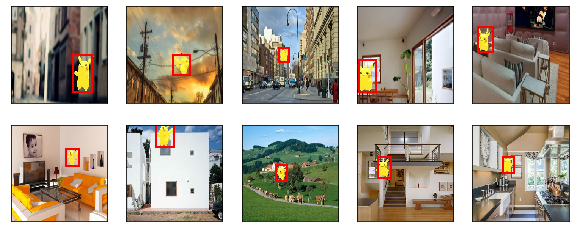

In [4]:
imgs = (batch.data[0][0:10].transpose((0, 2, 3, 1))) / 255
axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, label in zip(axes, batch.label[0][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['r'])

# 单发多框检测（SSD）

我们在前几节分别介绍了边界框、锚框、多尺度目标检测和数据集，下面我们基于这些背景知识来构造一个目标检测模型：单发多框检测（single shot multibox detection，SSD）[1]。它简单、快速，并得到了广泛应用。该模型的一些设计思想和实现细节常适用于其他目标检测模型。


## 定义模型

图9.4描述了单发多框检测模型的设计。它主要由一个基础网络块和若干个多尺度特征块串联而成。其中基础网络块用来从原始图像中抽取特征，因此一般会选择常用的深度卷积神经网络。单发多框检测论文中选用了在分类层之前截断的VGG [1]，现在也常用ResNet替代。我们可以设计基础网络，使它输出的高和宽较大。这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小（如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。如此一来，图9.4中越靠近顶部的多尺度特征块输出的特征图越小，故而基于特征图生成的锚框也越少，加之特征图中每个单元感受野越大，因此更适合检测尺寸较大的目标。由于单发多框检测基于基础网络块和各个多尺度特征块生成不同数量和不同大小的锚框，并通过预测锚框的类别和偏移量（即预测边界框）检测不同大小的目标，因此单发多框检测是一个多尺度的目标检测模型。

![单发多框检测模型主要由一个基础网络块和若干多尺度特征块串联而成](../d2l-zh/img/ssd.svg)


接下来我们介绍如何实现图中的各个模块。我们先介绍如何实现类别预测和边界框预测。

### 类别预测层

设目标的类别个数为$q$。每个锚框的类别个数将是$q+1$，其中类别0表示锚框只包含背景。在某个尺度下，设特征图的高和宽分别为$h$和$w$，如果以其中每个单元为中心生成$a$个锚框，那么我们需要对$hwa$个锚框进行分类。如果使用全连接层作为输出，很容易导致模型参数过多。回忆[“网络中的网络（NiN）”](../chapter_convolutional-neural-networks/nin.ipynb)一节介绍的使用卷积层的通道来输出类别预测的方法。单发多框检测采用同样的方法来降低模型复杂度。

具体来说，类别预测层使用一个保持输入高和宽的卷积层。这样一来，输出和输入在特征图宽和高上的空间坐标一一对应。考虑输出和输入同一空间坐标$(x,y)$：输出特征图上$(x,y)$坐标的通道里包含了以输入特征图$(x,y)$坐标为中心生成的所有锚框的类别预测。因此输出通道数为$a(q+1)$，其中索引为$i(q+1) + j$（$0 \leq j \leq q$）的通道代表了索引为$i$的锚框有关类别索引为$j$的预测。

下面我们定义一个这样的类别预测层：指定参数$a$和$q$后，它使用一个填充为1的$3\times3$卷积层。该卷积层的输入和输出的高和宽保持不变。

In [5]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, contrib, gluon, image, init, nd
from mxnet.gluon import loss as gloss, nn
import time

def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3, padding=1)

### 边界框预测层

边界框预测层的设计与类别预测层的设计类似。唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是$q+1$个类别。

In [6]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

### 连结多尺度的预测

前面提到，单发多框检测根据多个尺度下的特征图生成锚框并预测类别和偏移量。由于每个尺度上特征图的形状或以同一单元为中心生成的锚框个数都可能不同，因此不同尺度的预测输出形状可能不同。

在下面的例子中，我们对同一批量数据构造两个不同尺度下的特征图`Y1`和`Y2`，其中`Y2`相对于`Y1`来说高和宽分别减半。以类别预测为例，假设以`Y1`和`Y2`特征图中每个单元生成的锚框个数分别是5和3，当目标类别个数为10时，类别预测输出的通道数分别为$5\times(10+1)=55$和$3\times(10+1)=33$。预测输出的格式为(批量大小, 通道数, 高, 宽)。可以看到，除了批量大小外，其他维度大小均不一样。我们需要将它们变形成统一的格式并将多尺度的预测连结，从而让后续计算更简单。

In [7]:
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(nd.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(nd.zeros((2, 16, 10, 10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的(批量大小, 高$\times$宽$\times$通道数)的格式，以方便之后在维度1上的连结。

In [8]:
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

这样一来， 尽管Y1和Y2形状不同，我们仍然可以将两个同一批量不同尺寸的预测结果连结在一起

In [9]:
concat_preds([Y1, Y2]).shape

(2, 25300)

### 高和宽减半块

为了在多尺度检测目标，下面定义高和宽减半块`down_sample_blk`。它串联了两个填充为1的$3\times3$卷积层和步幅为2的$2\times2$最大池化层。我们知道，填充为1的$3\times3$卷积层不改变特征图的形状，而后面的池化层则直接将特征图的高和宽减半。由于$1\times 2+(3-1)+(3-1)=6$，输出特征图中每个单元在输入特征图上的感受野形状为$6\times6$。可以看出，高和宽减半块使输出特征图中每个单元的感受野变得更广阔。

In [10]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

测试高和宽减半块的前向计算，改变输入的通道数，并将高和宽减半

In [11]:
forward(nd.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

### 基础网络块

基础网络块用来从原始图像中抽取特征。为了计算简洁，我们在这里构造一个小的基础网络。该网络串联3个高和宽减半块，并逐步将通道数翻倍。当输入的原始图像的形状为$256\times256$时，基础网络块输出的特征图的形状为$32 \times 32$。

In [12]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

forward(nd.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

### 完整的模型

![ssd](./imgs/ssd.png)

单发多框检测模型一共包含5个模块，每个模块输出的特征图既用来生成锚框，又用来预测这些锚框的类别和偏移量。第一模块为基础网络块，第二模块至第四模块为高和宽减半块，第五模块使用全局最大池化层将高和宽降到1。因此第二模块至第五模块均为图9.4中的多尺度特征块。

In [13]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

接下来，我们定义每个模块如何进行前向计算。与之前介绍的卷积神经网络不同，这里不仅返回卷积计算输出的特征图`Y`，还返回根据`Y`生成的当前尺度的锚框，以及基于`Y`预测的锚框类别和偏移量。

In [14]:
def blk_forrward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_pred = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_pred, bbox_preds)

我们提到，图9.4中较靠近顶部的多尺度特征块用来检测尺寸较大的目标，因此需要生成较大的锚框。我们在这里先将0.2到1.05之间均分5份，以确定不同尺度下锚框大小的较小值0.2、0.37、0.54等，再按$\sqrt{0.2 \times 0.37} = 0.272$、$\sqrt{0.37 \times 0.54} = 0.447$等来确定不同尺度下锚框大小的较大值。

In [15]:
size = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], 
        [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(size[0]) + len(ratios[0]) - 1

In [16]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            # 赋值语句self.blk_i = get_blk(i)
            setattr(self, 'blk_%d' % i, get_blk(i))
            setattr(self, 'cls_%d' % i, cls_predictor(num_anchors, num_classes))
            setattr(self, 'bbox_%d' % i, bbox_predictor(num_anchors))
        
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self, 'blk_%d' % i) 即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forrward(
                X, getattr(self, 'blk_%d' % i), size[i], ratios[i], 
                getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))
        return (nd.concat(*anchors, dim=1), 
                concat_preds(cls_preds).reshape((
                    0, -1, self.num_classes + 1)), concat_preds(bbox_preds))

我们创建单发多框检测模型实例并对一个高和宽均为256像素的小批量图像`X`做前向计算。我们在之前验证过，第一模块输出的特征图的形状为$32 \times 32$。由于第二至第四模块为高和宽减半块、第五模块为全局池化层，并且以特征图每个单元为中心生成4个锚框，每个图像在5个尺度下生成的锚框总数为$(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$。

In [17]:
net = TinySSD(num_classes=1)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors: ', anchors.shape)
print('output class preds: ', cls_preds.shape)
print('output bbox preds: ', bbox_preds.shape)

output anchors:  (1, 5444, 4)
output class preds:  (32, 5444, 2)
output bbox preds:  (32, 21776)


## 训练模型

下面我们描述如何一步步训练单发多框检测模型来进行目标检测。

### 读取数据集和初始化

我们读取[“目标检测数据集（皮卡丘）”](object-detection-dataset.ipynb)一节构造的皮卡丘数据集。

In [18]:
batch_size = 4
train_iter, _ = d2l.load_data_pikachu(batch_size)

在皮卡丘数据集中，目标的类别数为1。定义好模型以后，我们需要初始化模型参数并定义优化算法。

In [35]:
ctx, net = d2l.try_gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.3, 'wd': 5e-4})

### 定义损失函数和评价函数

目标检测有两个损失：一是有关锚框类别的损失，我们可以重用之前图像分类问题里一直使用的交叉熵损失函数；二是有关正类锚框偏移量的损失。预测偏移量是一个回归问题，但这里不使用前面介绍过的平方损失，而使用$L_1$范数损失，即预测值与真实值之间差的绝对值。掩码变量`bbox_masks`令负类锚框和填充锚框不参与损失的计算。最后，我们将有关锚框类别和偏移量的损失相加得到模型的最终损失函数。

In [20]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

我们可以沿用准确率评价分类结果。因为使用了$L_1$范数损失，我们用平均绝对误差评价边界框的预测结果。

In [21]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维， argmax需要制定最后一维
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_labels) * bbox_masks).abs().sum().asscalar()

### 训练模型

在训练模型时，我们需要在模型的前向计算过程中生成多尺度的锚框`anchors`，并为每个锚框预测类别`cls_preds`和偏移量`bbox_preds`。之后，我们根据标签信息`Y`为生成的每个锚框标注类别`cls_labels`和偏移量`bbox_labels`。最后，我们根据类别和偏移量的预测和标注值计算损失函数。为了代码简洁，这里没有评价测试数据集。

In [36]:
for epoch in range(20):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset()  # 从头读取数据
    start = time.time()
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # 生成多尺度的锚框, 为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size
        
    if (epoch + 1) % 5 == 0:
        print('epoch % 2d, class_error %.2e, bbox mae %.2e, time %.1f, sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))

epoch  5, class_error 2.45e-03, bbox mae 0.00e+00, time 35.1, sec
epoch  10, class_error 2.11e-03, bbox mae 0.00e+00, time 37.3, sec
epoch  15, class_error 1.85e-03, bbox mae 0.00e+00, time 41.5, sec
epoch  20, class_error 1.83e-03, bbox mae 0.00e+00, time 39.1, sec


## 预测目标

在预测阶段，我们希望能把图像里面所有我们感兴趣的目标检测出来。下面读取测试图像，将其变换尺寸，然后转成卷积层需要的四维格式。

In [23]:
img = image.imread('../d2l-zh/img/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)

通过`MultiBoxDetection`函数根据锚框及其预测偏移量得到预测边界框，并通过非极大值抑制移除相似的预测边界框。

In [24]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]

output = predict(X)

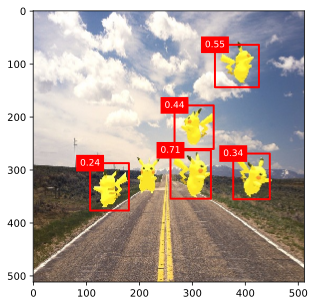

In [38]:
d2l.set_figsize((5, 5))

def display(img, output, threshold):
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'r')

display(img, output, threshold=0.2)

### 损失函数

将预测偏移量用到的$L_1$范数损失替换为平滑$L_1$范数损失。它在零点附近使用平方函数从而更加平滑，这是通过一个超参数$\sigma$来控制平滑区域的：

$$
f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \text{if }|x| < 1/\sigma^2\\
    |x|-0.5/\sigma^2,& \text{otherwise}
    \end{cases}
$$

当$\sigma$很大时该损失类似于$L_1$范数损失。当它较小时，损失函数较平滑。

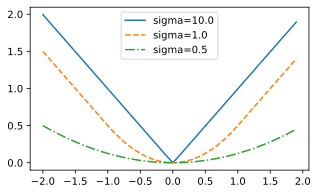

In [33]:
sigma = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = nd.arange(-2, 2, 0.1)
d2l.set_figsize((5, 3))

for l, s in zip(lines, sigma):
    y = nd.smooth_l1(x, scalar=s)
    d2l.plt.plot(x.asnumpy(), y.asnumpy(), l, label='sigma=%.1f' % s)
d2l.plt.legend();

在类别预测时，实验中使用了交叉熵损失：设真实类别$j$的预测概率是$p_j$，交叉熵损失为$-\log p_j$。我们还可以使用焦点损失（focal loss）[2]：给定正的超参数$\gamma$和$\alpha$，该损失的定义为

$$ - \alpha (1-p_j)^{\gamma} \log p_j.$$

可以看到，增大$\gamma$可以有效减小正类预测概率较大时的损失。

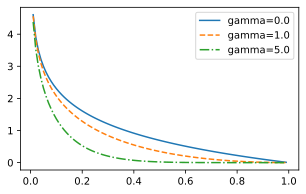

In [34]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * x.log()

x = nd.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x.asnumpy(), focal_loss(gamma, x).asnumpy(), l, label='gamma=%.1f' % gamma)

d2l.plt.legend()